<a href="https://colab.research.google.com/github/tettey-exploits/spam_image_classifier_colab_notebook/blob/main/TELESA_AI_Workshop_Day_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Spam Image Classifier

  In this notebook, we build and train an image classification model to differentiate between spam images and non-spam images.


*   **Spam Images**: Generally unwanted images that take too much space on your mobile phone. These may include fliers from agenda boys, marketing fliers, etc. This is the class we want to identify and hence represents our positive class

*   **Non-spam Images**: Images on your phone you would want to keep. Example: your nice Sunday after church photos. This is our negative class.






In [ ]:
# We begin by importing the neccesary libraries
import zipfile
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
import numpy as np
import random
from google.colab import drive
import shutil
import gdown
import seaborn as sns
from IPython.display import clear_output
import time
import pandas as pd
import cv2

In [ ]:
!gdown 1N5bUudQFcJd-1-zu90S0skoR7K2iSydi  # download the dataset from google drive

Downloading...
From (original): https://drive.google.com/uc?id=1N5bUudQFcJd-1-zu90S0skoR7K2iSydi
From (redirected): https://drive.google.com/uc?id=1N5bUudQFcJd-1-zu90S0skoR7K2iSydi&confirm=t&uuid=1ae567e9-492b-476d-bbd9-9257908298f2
To: /content/project_aid_new_dataset.zip
100% 412M/412M [00:03<00:00, 112MB/s]


## Data Preparation
The first step in builing your AI model. To prepare the data, we need to:


1.   Download and extract the data.
2.   Divide the entire dataset into train and validation sets.

*   **Traing set**: This is the data our AI model learns from. In a real project, it must capture as much as possible everything your model would 'see' under deployment. Usually occupies 80% of the entire dataset.
*   **Validation set**: With this data, we test our model to see how well it performs.  Usually occupies 20% of the entire dataset.
*   **Test set**: Engineers use this data as the last and final way to evaluate the performance of their trained model.


In [ ]:
# !rm -r project_aid_new_dataset/
dataset_path = "/content/project_aid_new_dataset/"
!mkdir "/content/project_aid_new_dataset"  # create a new folder

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/project_aid_new_dataset.zip")
zip_ref.extractall(dataset_path)
zip_ref.close()

In [ ]:
# Inspect the data. List out the number of folders and/or images in a specified directory.
#   Repeat for every directory in the specified directory
def inspect_dataset_dir(path=dataset_path):
  for dirpath, dirnames, filenames in os.walk(path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

inspect_dataset_dir()

There are 2 directories and 0 images in /content/project_aid_new_dataset/
There are 0 directories and 1000 images in /content/project_aid_new_dataset/non_spam
There are 0 directories and 2149 images in /content/project_aid_new_dataset/spam


### Divide dataset into train and test data
**NB:** With ML frameworks, there are easier ways to do this. However, we are manually dividing the data to help us understand what is goinig on.

We create a third folder "test images", where we randomly pick images from and run a

In [ ]:
start = time.time()

# path to destination folders
train_folder = os.path.join(dataset_path, 'train')
val_folder = os.path.join(dataset_path, 'val')
test_folder = os.path.join(dataset_path, 'test_images')

# Define a list of image extensions
image_extensions = ['.jpg', '.jpeg', '.png']

# Create a list of class_names in 'data_path'
class_list = [class_name for class_name in os.listdir(dataset_path)]


for class_name in class_list:
  # Create a list of image filenames in the appropraite class_folder. i.e 'data_path' + "/" + class_name
  imgs_list = [filename for filename in os.listdir(dataset_path + "/" + class_name) if os.path.splitext(filename)[-1] in image_extensions]
  # print(imgs_list)

  # Shuffle the list of image filenames
  np.random.shuffle(imgs_list)

  # determine the number of images for each set
  train_size = int(len(imgs_list) * 0.7)
  val_size = int(len(imgs_list) * 0.25)
  test_size = int(len(imgs_list) * 0.5)

  # Create destination folders if they don't exist
  for folder_path in [train_folder, val_folder, test_folder]:
      if not os.path.exists(folder_path+ "/" + class_name):
          os.makedirs(folder_path+ "/" + class_name)

  # Copy image files to destination folders
  for i, f in enumerate(imgs_list):
      if i < train_size:
          dest_folder = train_folder + "/" + class_name
      elif i < train_size + val_size:
          dest_folder = val_folder + "/" + class_name
      else:
          dest_folder = test_folder + "/" + class_name
      shutil.copy(os.path.join(dataset_path + "/" + class_name, f), os.path.join(dest_folder, f))

print(time.time() - start)


4.650147199630737


In [ ]:
# re-inspect dataset and confirm dataset partition was successful
inspect_dataset_dir()

There are 5 directories and 0 images in /content/project_aid_new_dataset/
There are 2 directories and 0 images in /content/project_aid_new_dataset/val
There are 0 directories and 250 images in /content/project_aid_new_dataset/val/non_spam
There are 0 directories and 537 images in /content/project_aid_new_dataset/val/spam
There are 2 directories and 0 images in /content/project_aid_new_dataset/test_images
There are 0 directories and 50 images in /content/project_aid_new_dataset/test_images/non_spam
There are 0 directories and 108 images in /content/project_aid_new_dataset/test_images/spam
There are 0 directories and 1000 images in /content/project_aid_new_dataset/non_spam
There are 2 directories and 0 images in /content/project_aid_new_dataset/train
There are 0 directories and 700 images in /content/project_aid_new_dataset/train/non_spam
There are 0 directories and 1504 images in /content/project_aid_new_dataset/train/spam
There are 0 directories and 2149 images in /content/project_aid_

In [ ]:
class_names = os.listdir(f"{dataset_path}/train/")
print(class_names)

['non_spam', 'spam']


### Visualize data

At all times, we want to visualize the data to make sure we are doing correctly.

In [ ]:
def view_random_image(target_class, target_dir=dataset_path, category="train"):
  target_folder = target_dir + category + "/" + target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  return img

['IMG-20230704-WA0002.jpg']
Image has shape (1080, 810, 3)


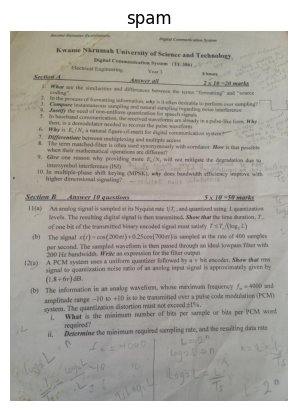

In [ ]:
class_name = random.choice(class_names)  # select a random class
img = view_random_image(class_name, category="train")
print(f"Image has shape {img.shape}")

### Use Tensorflow ImageDataGenerator class to load images


**NB:** This method is now deprecated in Tensorflow and should not be used in your future projects. A fun exercise would be to figure out what is the standard way of doing it now


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
TARGET_SIZE = (256, 256)


train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

# Setup paths to our data directories
train_dir = f"{dataset_path}/train"
val_dir = f"{dataset_path}/val"

# Import dat from directories and turn them into batches
train_data = train_datagen.flow_from_directory(f"{dataset_path}/train",
                                                batch_size=BATCH_SIZE,
                                                target_size=TARGET_SIZE,
                                                class_mode="binary",
                                                shuffle=True)

val_data = val_datagen.flow_from_directory(f"{dataset_path}/val",
                                               target_size=TARGET_SIZE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="binary",
                                               shuffle=True)

Found 2204 images belonging to 2 classes.
Found 787 images belonging to 2 classes.


## Model Training

### Build Model

1. **loss="binary_crossentropy"**:
   - This specifies the loss function used during training. `binary_crossentropy` is typically used for binary classification tasks where the model predicts either of two classes (0 or 1).

2. **optimizer=tf.keras.optimizers.Adam()**:
   - This defines the optimizer used to minimize the loss function. `Adam` is an adaptive learning rate optimization algorithm that is commonly used because it efficiently computes individual learning rates for different parameters.

3. **metrics**:
   - Metrics are used to evaluate the performance of the model. Here:
     - `accuracy` measures the fraction of correctly classified samples.
     - `Precision` is a metric that quantifies the number of true positive predictions divided by the number of true positives plus false positives. It is often used in binary classification problems when the aim is to minimize false positives.
     - `Recall` (also known as sensitivity or true positive rate) measures the fraction of true positives that were correctly identified by the model. It is useful when the goal is to capture as many positives as possible.

These components are crucial for configuring and evaluating the performance of a neural network model.

In [ ]:
# Build th CNN model ( same as the tTiny VGG on the CNN explainer website)
cnn_model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(filters=20,
                                                               kernel_size=3,
                                                               activation="relu",
                                                               input_shape=(256, 256, 3)),
                                        tf.keras.layers.Conv2D(20, 5, activation="relu"),
                                        tf.keras.layers.MaxPool2D(pool_size=2,
                                                                  padding="valid"),
                                        tf.keras.layers.Conv2D(20, 5, activation="relu"),
                                        tf.keras.layers.Conv2D(20, 5, activation="relu"),
                                        tf.keras.layers.MaxPool2D(2),
                                        tf.keras.layers.Conv2D(20, 5, activation="relu"),
                                        tf.keras.layers.MaxPool2D(pool_size=2,
                                                                  padding="valid"),
                                        tf.keras.layers.Conv2D(20, 5, activation="relu"),
                                        tf.keras.layers.Conv2D(20, 5, activation="relu"),
                                        tf.keras.layers.MaxPool2D(2),
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(1, activation="sigmoid")
                                        ])

# Compile the model
cnn_model.compile(loss="binary_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
# generate a summary of the model architure
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 20)      560       
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 20)      10020     
                                                                 
 max_pooling2d (MaxPooling2  (None, 125, 125, 20)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 20)      10020     
                                                                 
 conv2d_3 (Conv2D)           (None, 117, 117, 20)      10020     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 58, 58, 20)        0         
 g2D)                                                   

### Train Model

Let's use the untrained model to predict an image class. We wouldn't expect the model's performance to be good.

Run the cell multiple times

['img_0113.jpeg']
1/1 [==============================] - 3s 3s/step
Predicted class: spam
Actual class: non_spam


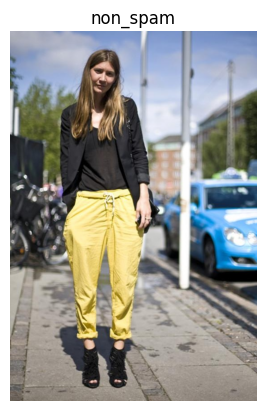

In [ ]:
def predict_random_image_class():
  # Pick a random image from the test images directory, and use the model to predict its class.
  class_oi = random.choice(class_names)  # class of interest
  img = view_random_image(target_class=class_oi, category="test_images")  # pick random image

  img = cv2.resize(img, (256, 256))  # resize images into proper shape
  model_img = np.expand_dims(img, axis=0)  # expand dimension to match model input shape
  result = cnn_model.predict(model_img)  # use model to perform inference on image
  predicted_class = class_names[round(result[0][0])]
  print(f"Predicted class: {predicted_class}")
  print(f"Actual class: {class_oi}")

predict_random_image_class()

Now, let's evaluate the untrained model on the entire validation data. This would be very low.

In [ ]:
cnn_model.evaluate(val_data)

13/13 [==============================] - 12s 558ms/step - loss: 3.1300 - accuracy: 0.3113 - precision: 0.4932 - recall: 0.3371


[3.129960775375366,
 0.31130877137184143,
 0.4931880235671997,
 0.3370577394962311]

Additionally, let's visualize the confusion matrix to gain deeper insights into the model's performance.

In a confusion matrix:

The confusion matrix is a fundamental tool in evaluating the performance of a classification model. It's typically organized into a table format. Here's how it relates to the confusion matrix:

1. **True Positives (TP)**: This is the top left cell of the confusion matrix. It counts the number of correctly predicted positive instances (instances where the model predicted the class as positive and it actually belongs to the positive class).

2. **False Positives (FP)**: This would be the top bottom left of the confusion matrix. It counts the instances where the model incorrectly predicted positive when the actual class was negative.

3. **True Negatives (TN)**: This corresponds to the bottom right corner of the confusion matrix. It counts the instances where the model correctly predicted negative when the actual class was negative.

4. **False Negatives (FN)**: This would be the top right corner of the confusion matrix. It counts the instances where the model incorrectly predicted negative when the actual class was positive.

The confusion matrix thus provides a clear summary of the model's predictions versus the actual outcomes across these four categories, helping to evaluate its accuracy, precision, recall, and other performance metrics.

In [ ]:
labels = list(val_data.labels)
predictions = cnn_model.predict(val_data)  # get predictions on validation data
predictions = tf.squeeze(tf.round(predictions))

cm = tf.math.confusion_matrix(labels, predictions, num_classes=len(class_names))  # create confusion matrix

13/13 [==============================] - 8s 577ms/step


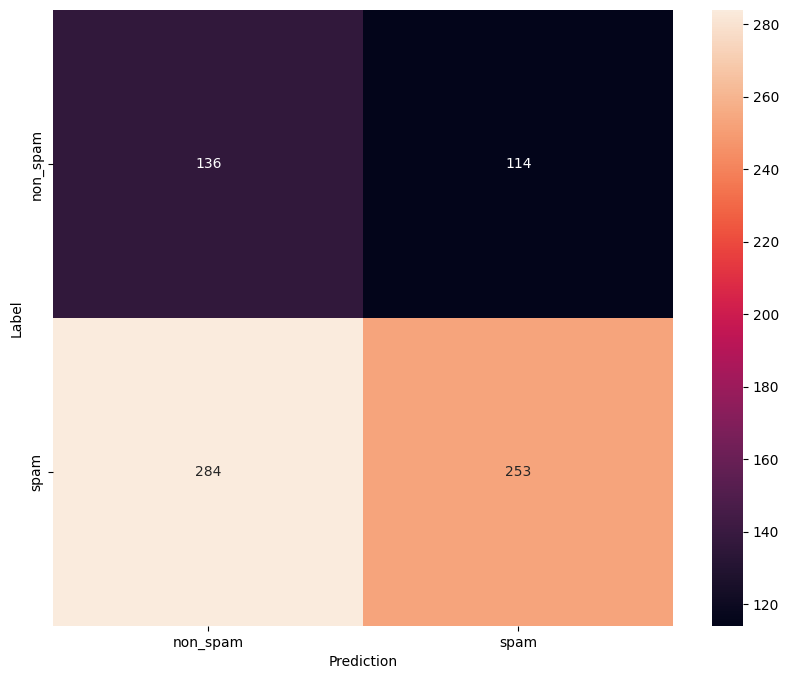

In [ ]:
def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels,
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

show_confusion_matrix(cm, class_names)

### Training the Model:

The code snippet provided shows a typical usage of the `fit` method in TensorFlow/Keras to train a convolutional neural network (CNN) model (`cnn_model`) on training data (`train_data`) and validate it on validation data (`val_data`). Let's break down the parameters used in this `fit` method call:

- **train_data**: This is typically a `tf.data.Dataset` object containing the training data. It provides batches of data to the model during training.

- **epochs**: Specifies the number of epochs (iterations over the entire training dataset) to train the model. If set to 10, meaning the model will go through the entire training dataset 10 times. Generally, model performance improves after every epoch.

- **steps_per_epoch=len(train_data)**: This parameter defines how many batches of samples to draw from the dataset in each epoch. `len(train_data)` gives the total number of batches in the training dataset. This is useful when the dataset is large and doesn't fit into memory all at once, so the training is done in batches.

- **validation_data=val_data**: This is the dataset used for validation during training. It can also be a `tf.data.Dataset` object. The model performance on this data is evaluated after each epoch.

- **validation_steps=len(val_data)**: Similar to `steps_per_epoch`, this parameter defines how many batches to draw from the validation dataset (`val_data`) during each epoch for validation. `len(val_data)` gives the total number of batches in the validation dataset.

The `fit` method will train the `cnn_model` for the set amount of epochs (`epochs=EPOCH`), iterating over `len(train_data)` batches of training data per epoch, and validating the model's performance on `val_data` using `len(val_data)` batches of validation data after each epoch.

After running this `fit` method, the `history_cnn` object will contain the training history, including metrics such as loss and accuracy, which can be used for evaluation and visualization.

In [ ]:
# Fit the model
EPOCH = 10
history_cnn = cnn_model.fit(train_data, epochs=10,
                            steps_per_epoch=len(train_data),
                            validation_data=val_data,
                            validation_steps=len(val_data),
                            )

Epoch 1/10
35/35 [==============================] - 46s 988ms/step - loss: 1.0923 - accuracy: 0.7573 - precision: 0.8041 - recall: 0.8517 - val_loss: 0.3758 - val_accuracy: 0.8335 - val_precision: 0.9432 - val_recall: 0.8045
Epoch 2/10
35/35 [==============================] - 29s 829ms/step - loss: 0.2295 - accuracy: 0.8975 - precision: 0.9112 - recall: 0.9415 - val_loss: 0.2819 - val_accuracy: 0.8856 - val_precision: 0.9934 - val_recall: 0.8380
Epoch 3/10
35/35 [==============================] - 29s 833ms/step - loss: 0.1365 - accuracy: 0.9437 - precision: 0.9534 - recall: 0.9648 - val_loss: 0.1007 - val_accuracy: 0.9632 - val_precision: 0.9885 - val_recall: 0.9572
Epoch 4/10
35/35 [==============================] - 30s 858ms/step - loss: 0.0903 - accuracy: 0.9655 - precision: 0.9722 - recall: 0.9774 - val_loss: 0.0799 - val_accuracy: 0.9670 - val_precision: 0.9812 - val_recall: 0.9702
Epoch 5/10
35/35 [==============================] - 29s 837ms/step - loss: 0.0516 - accuracy: 0.9791

### Plot Learning Curve:
#### Plot the model performance against the number of iterations. You should expect the loss curves decreasing whiles the other cureves (accuracy, precision, recall) increasing

<Axes: >

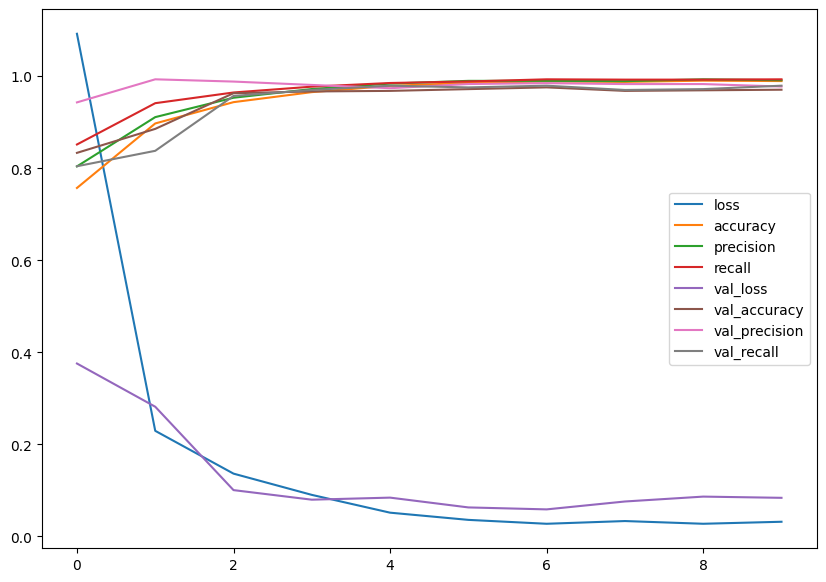

In [ ]:
# Plot model learning curve
pd.DataFrame(history_cnn.history).plot(figsize=(10, 7))

## Evaluate model performance on test images

In [ ]:
cnn_model.evaluate(val_data)

13/13 [==============================] - 7s 537ms/step - loss: 0.0839 - accuracy: 0.9708 - precision: 0.9777 - recall: 0.9795


[0.08390476554632187,
 0.9707750678062439,
 0.9776951670646667,
 0.9795158505439758]

['IMG-20230815-WA0013.jpg']
1/1 [==============================] - 0s 19ms/step
Predicted class: spam
Actual class: spam


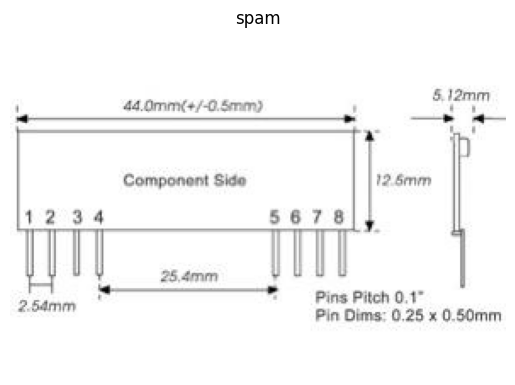

In [ ]:
# Pick a random image from the test images directory, and use the trained model to predict its class.
#  After training we expect to see good results
predict_random_image_class()

## Save model in .keras format

In [ ]:
cnn_model.save("model.keras")

# Data Augmentation

Data augmentation is the process of artificially generating new data from existing data. The goal may be to:

*   **Reduce overfitting**: In this problem, the model performs very well on the training data. However, on the test/validation set, the model performs poorly.
*   **Reduce class imbalance**: Usually, for your given dataset, you want each class to to represented well in the dataset. Meaning, the number of data-points(images) in one class must not exceed too much the number of data-points in the other classes. In binary classification, we usually expect a distribution between 50-50 and 70-30.

There are many ways to perform data augmentation, depending on what you want to achieve. You can apply data-augmentation directly to the training data as the model trains, or data augmentation can be performed prior to training.

Due to the class imbalance problem we have in our dataset, we wiil apply data augmentation, first to the class with the lower distribution(non-spam). This is so that we can increase the number of images in that class.

Later, we will apply data augmentation to the entire dataset. With this, we want to reduce overfitting. PS: Our model does not have the overfitting problem :). However, we are doing this just to demonstrate how its done.


**NB: There are many ways to reduce overfitting. Data augmentation is just one of them.**



## Directly Augment the images in the "spam images" folder

In [ ]:
def augment_classes(underrepresented_class_names):
  for class_name in underrepresented_class_names:  # iterate over each item in the list of underrepresented classes
    path = train_folder + "/" + class_name
    files = [f for f in os.listdir(path)]  # get the list of files in the directory
    name = 0
    for i, image in enumerate(files):
      clear_output()
      print(f"Augmenting {len(files)} images in {path}")
      print(f"Augmenting image {i+1} of {len(files)}")
      file_path = path + "/" + image
      new_file_path = path + str(time.time())  + image
      loaded_img = tf.keras.utils.load_img(file_path)  # Load the image

      transformed_image = tf.image.random_brightness(loaded_img, 0.2)
      transformed_img_array = tf.keras.utils.img_to_array(transformed_image) #
      img = tf.keras.utils.save_img(path + "/" + str(time.time()) + image , transformed_img_array)  # save image


      transformed_image = tf.image.random_saturation(loaded_img, 0.75, 1.25)
      transformed_img_array = tf.keras.utils.img_to_array(transformed_image) #
      img = tf.keras.utils.save_img(path + "/" + str(time.time()) + image, transformed_img_array)  # save image

start = time.time()
augment_classes(["non_spam"])
print(time.time() - start)

Augmenting 700 images in /content/project_aid_new_dataset/train/non_spam
Augmenting image 700 of 700
19.248676300048828


In [ ]:
inspect_dataset_dir()

There are 5 directories and 0 images in /content/project_aid_new_dataset/
There are 2 directories and 0 images in /content/project_aid_new_dataset/val
There are 0 directories and 250 images in /content/project_aid_new_dataset/val/non_spam
There are 0 directories and 537 images in /content/project_aid_new_dataset/val/spam
There are 2 directories and 0 images in /content/project_aid_new_dataset/test_images
There are 0 directories and 50 images in /content/project_aid_new_dataset/test_images/non_spam
There are 0 directories and 108 images in /content/project_aid_new_dataset/test_images/spam
There are 0 directories and 1000 images in /content/project_aid_new_dataset/non_spam
There are 2 directories and 0 images in /content/project_aid_new_dataset/train
There are 0 directories and 2100 images in /content/project_aid_new_dataset/train/non_spam
There are 0 directories and 1504 images in /content/project_aid_new_dataset/train/spam
There are 0 directories and 2149 images in /content/project_aid

## Use the Tensorflow ImageGenerator Class to load your data.

#### Like we did before, we have to load the images using the *ImageDataGeneratorClass*.


---



**Very Important!!!**

Currently, in the following cell, ```do_shuffle``` has been set to ```False``` to make visualization possible in the next cell.

After executing the cell labeled 'Visualize', remember to change ```do_shuffle``` to ```True``` and rerun it before proceeding to train the model.

```
do_shuffle = True
```

Failure to set ```do_shuffle``` to ```True``` before training may result in poor model performance.




In [ ]:
# Create image generator training instance with augmented data
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=0.2,
                                             zoom_range=0.2,
                                             shear_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             horizontal_flip=True)

# Create training instance without augmented data.
# This is because, we want to compare augmented data to the non-augmented data
train_datagen = ImageDataGenerator(rescale=1/255.)

# Generally, Augmentation to not applied to test and validation
test_datagen = ImageDataGenerator(rescale=1/255.)  # Test data will not be augmented
val_datagen = ImageDataGenerator(rescale=1/255.)  # Test data will not be augmented

In [ ]:
# keep shuffle=False to enable visualzation in the next cell
do_shuffle = False

BATCH_SIZE = 64
TARGET_SIZE = (256, 256)

train_data_augmented = train_datagen_augmented.flow_from_directory(f"{dataset_path}/train",
                                                                   batch_size=BATCH_SIZE,
                                                                   target_size=TARGET_SIZE,
                                                                   class_mode="binary",
                                                                   shuffle=do_shuffle)

train_data = train_datagen.flow_from_directory(f"{dataset_path}/train",
                                                batch_size=BATCH_SIZE,
                                                target_size=TARGET_SIZE,
                                                class_mode="binary",
                                                shuffle=do_shuffle)

val_data = val_datagen.flow_from_directory(f"{dataset_path}/val",
                                               target_size=TARGET_SIZE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="binary",
                                               shuffle=do_shuffle)

Found 3604 images belonging to 2 classes.
Found 3604 images belonging to 2 classes.
Found 787 images belonging to 2 classes.


### Visualize... Compare augmented data to non-augmented data

**NB:** You can run the cell multiple times to see different results.

In [ ]:
images, labels = train_data.next()
augmented_images, augmented_images_labels = train_data_augmented.next()

rand_num = random.randint(0, 64)
print(f"Showing image number: {rand_num}")
plt.title(f"Original Image")
plt.imshow(images[rand_num])
plt.axis(False)
plt.figure()
plt.title(f"Augmented Image")
plt.imshow(augmented_images[rand_num])
plt.axis(False)

## Creating a model to fit on my augmented model



In [ ]:
# Build th CNN model ( same as the tTiny VGG on the CNN explainer website)
cnn_model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(filters=16,
                                                               kernel_size=3,
                                                               activation="relu",
                                                               input_shape=(256, 256, 3)),
                                        tf.keras.layers.Conv2D(16, 3, activation="relu"),
                                        tf.keras.layers.MaxPool2D(pool_size=2,
                                                                  padding="valid"),
                                        tf.keras.layers.Conv2D(32, 3, activation="relu"),
                                        tf.keras.layers.Conv2D(32, 3, activation="relu"),
                                        tf.keras.layers.MaxPool2D(2),
                                        tf.keras.layers.Conv2D(64, 3, activation="relu"),
                                        tf.keras.layers.MaxPool2D(pool_size=2,
                                                                  padding="valid"),
                                        tf.keras.layers.Conv2D(128, 3, activation="relu"),
                                        tf.keras.layers.Conv2D(128, 3, activation="relu"),
                                        tf.keras.layers.MaxPool2D(2),
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(1, activation="sigmoid")
                                        ])

# Compile the model
cnn_model.compile(loss="binary_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

cnn_model.summary()

In [ ]:
# Fit my model on augmented data
augmented_data_history = cnn_model.fit(train_data,
                epochs=5,
                steps_per_epoch=len(train_data_augmented),
                validation_data=val_data,
                validation_steps=len(val_data),
                shuffle=True)


Epoch 1/5
57/57 [==============================] - 49s 667ms/step - loss: 0.7418 - accuracy: 0.5483 - precision_1: 0.4520 - recall_1: 0.3883 - val_loss: 0.7009 - val_accuracy: 0.3177 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/5
57/57 [==============================] - 36s 636ms/step - loss: 0.6842 - accuracy: 0.5827 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 0.6959 - val_accuracy: 0.3837 - val_precision_1: 1.0000 - val_recall_1: 0.0968
Epoch 3/5
57/57 [==============================] - 36s 632ms/step - loss: 0.6171 - accuracy: 0.6765 - precision_1: 0.7134 - recall_1: 0.3757 - val_loss: 1.2232 - val_accuracy: 0.6798 - val_precision_1: 0.6853 - val_recall_1: 0.9814
Epoch 4/5
57/57 [==============================] - 36s 629ms/step - loss: 0.5465 - accuracy: 0.7825 - precision_1: 0.7394 - recall_1: 0.7394 - val_loss: 0.3008 - val_accuracy: 0.8412 - val_precision_1: 0.9747 - val_recall_1: 0.7877
Epoch 5/5
57/57 [==============================] - 35s 6

In [ ]:
cnn_model.evaluate(val_data)

13/13 [==============================] - 8s 584ms/step - loss: 0.3855 - accuracy: 0.7942 - precision_1: 0.9699 - recall_1: 0.7207


[0.3855065405368805, 0.7941550016403198, 0.969924807548523, 0.7206704020500183]

### Visualize and Evaluate model performance.



*   **Plot Confusion Matrix**: It's an N x N matrix used for evaluating the performance of a classification model, where N is the number of target classes.




In [ ]:
labels = list(val_data.labels)
predictions = cnn_model.predict(val_data)
predictions = tf.squeeze(tf.round(predictions))

13/13 [==============================] - 10s 825ms/step


In [ ]:
cm =tf.math.confusion_matrix(labels, predictions, num_classes=len(class_names))

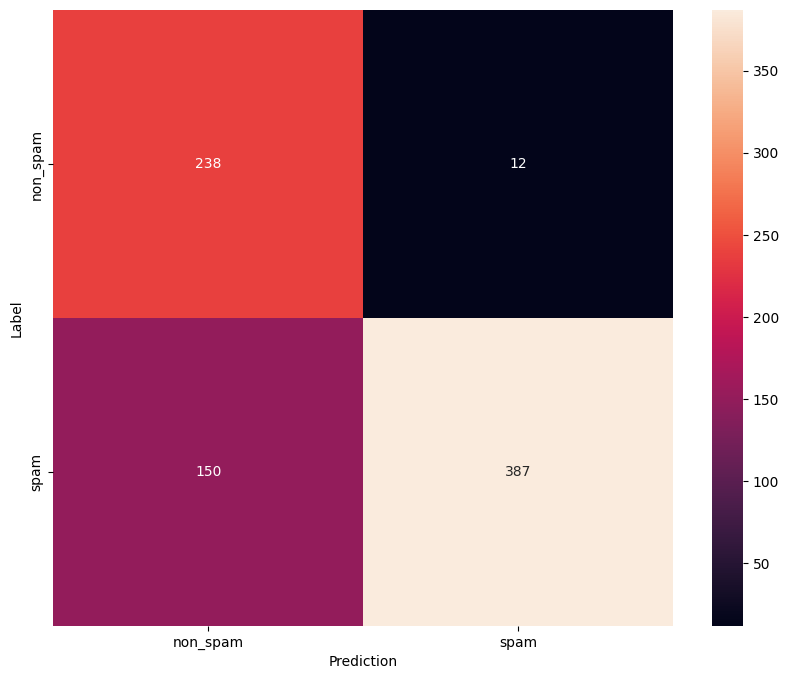

In [ ]:
show_confusion_matrix(cm, class_names)